# Data Exploration

**Author:** Ioakeim Ioakeim

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import csv
import xml.etree.cElementTree as et
from bokeh.io import show
from bokeh.io import output_notebook
from bokeh.models import LinearColorMapper
from bokeh.palettes import Viridis6 as palette
from bokeh.plotting import figure
output_notebook()
palette.reverse()
warnings.filterwarnings('ignore')
%matplotlib inline

Loading BokehJS ...

 **File Paths**

In [2]:
# File pathes for quick adjustment if places or directories change.
path_input = '00_data_input'
path_temp = '01_data_temp'
path_inter = '02_data_intermediate'
path_output = '03_data_output'
path_atlas = os.path.join(path_input, 'food_atlas.xls')
path_obesity = os.path.join(path_inter, 'obesity_refined_data.csv')
path_diabetes = os.path.join(path_inter, 'diabetes_refined_data.csv')
path_diabetes_description = os.path.join(path_inter, 'diabetes_refined_decription.csv')
path_state_geodata = os.path.join(path_input, 'us_state_geodata.csv')
path_counties_geodata = os.path.join(path_input, 'us_counties_geodata.csv')
path_metropolitan = os.path.join(path_output, 'population_data.csv')
path_fast_food = os.path.join(path_inter, 'fast_food_refined_data.csv')
path_fast_food_expenditure = os.path.join(path_inter, 'fast_food_expenditure_refined_data.csv')
path_fast_food_restaurant_count = os.path.join(path_inter, 'fast_food_restaurant_count_refined_data.csv')

# Background
Poverty and Obesity are two conditions which are thought to be related. Existing research suggests that there is a positive correlation between the two. 


# Objectives
To examine different socioeconomic factors, their impact on obesity, and the extend to which these factors influence obesity in the U.S.


# Data Sources
For this project, the purpose was to find a dataset which satisfies the several criteria, some of which include a reliable source, an adequate size, fine data granularity, recent and diverse data. Based on these criteria, the Food Access Research Atlas Data dataset was chosen as the main source of information.

This initial dataframe comes from the United States Department of Agriculture, which should be a reliable source of information, since it is a goverment entity. https://www.ers.usda.gov/data-products/food-environment-atlas/data-access-and-documentation-downloads/#Current%20Version. The data is provided as an Excel file with multiple sheets. The values of the food atlas are collected for each US county which are identified by their FIPS-code. The Version used was 5/18/2017, which was the most recent version at the time the project was done. The data span between 2001 and 2016, with most data ranging from 2007 to 2015, making them recent enough for the purpose of this research. The data are also mostly complete, including all 3142 counties, which belong to the 50 States , in most cases. The District of Columbia, which is not located in any state and is instead a territory of its own, is also included. In the data is seen as an additional county and state. U.S. territories and their county equivalents are excluded. Required Data was extracted from the original raw data source, it was then cleaned and in some cases refined.

# Indicators
All the indicators used in this study are directly derived from their corresponding datasets. These include medical terms such as diabetes and obesity. The collection of these data is mostly from public entities.

In [3]:
def get_data_range(series):
    df_description = series.describe()
    min_value = math.floor(df_description['min'])
    max_value = math.ceil(df_description['max'])
    values_list = series.tolist()
    return df_description, min_value, max_value, values_list

In [4]:
#Method for importing and reading state geodata
def read_state_geodata():
    nan = float('NaN')
    data = {}

    with open(path_state_geodata, 'r', newline='', encoding='utf8') as f:
        next(f)
        reader = csv.reader(f, delimiter=str(','), quotechar=str('"'))
        for row in reader:
            region, name, code, geometry, dummy = row
            xml = et.fromstring(geometry)
            lats = []
            lons = []
            for i, poly in enumerate(xml.findall('.//outerBoundaryIs/LinearRing/coordinates')):
                if i > 0:
                    lats.append(nan)
                    lons.append(nan)
                coords = (c.split(',')[:2] for c in poly.text.split())
                lat, lon = list(zip(*[(float(lat), float(lon)) for lon, lat in
                    coords]))
                lats.extend(lat)
                lons.extend(lon)
            
            # Fill one state entry in the data package.
            data[code] = {'name':name,'region':region,'lats':lats,'lons':lons}
    return data

In [5]:
#Method for plotting state geodata
def plot_state_map(title, value_name, series, value_limits=None):
    
    # Extract values from the series and get some data description.
    df_description, min_value, max_value, values_list = get_data_range(series)
    
    if (value_limits is not None):
        min_value = value_limits[0]
        max_value = value_limits[1]
    
    # Read the state geodata.
    states_raw = read_state_geodata()
    state_ids = sorted(states_raw)
    state_ids.remove('AK')
    state_ids.remove('HI')
    states = {}
    for state_id in state_ids:
        states[state_id] = states_raw[state_id]

    # Get the geographic coordinates.
    maxLon = -70
    state_xs = [state["lons"] for state in states.values()]
    for i in range(len(state_xs)):
        for k in range(len(state_xs[i])):
            if (state_xs[i][k] > maxLon):
                state_xs[i][k] = maxLon
        
    state_ys = [state["lats"] for state in states.values()]

    # Get the name of the states to map and set the values to plot.
    state_names = [state['name'] for state in states.values()]
    state_rates = values_list
    
    # Package the data into a dictionary needed for Bokeh.
    data = dict(x=state_xs, y=state_ys, name=state_names, rate=state_rates)
    
    color_mapper = LinearColorMapper(palette=palette, low=min_value, high=max_value)
    TOOLS = "pan,wheel_zoom,reset,hover,save"

    p = figure(
        title=title, x_axis_location=None, y_axis_location=None, plot_width=980,  plot_height=800,
        tooltips=[("Name", "@name"), (value_name, "@rate%")], tools=TOOLS)

    p.grid.grid_line_color = None
    p.hover.point_policy = "follow_mouse"
    p.patches('x', 'y', source=data,
              fill_color={'field': 'rate', 'transform': color_mapper},
              fill_alpha=0.7, line_color="white", line_width=0.5)

    show(p)

# Geoplotting
Due to the nature of the dataset, an atlas, a geospatial analysis was the first statistical analysis that was carried out. The goal here is to investigate, whether different parts of the United States have varying obesity rates. If that is the case, then the next step would be to identify the unterlying reason for these differences. 
For this investigation, the U.S. map was plotted, divided into its states, with each state showing the median value of obesity. The lighter, greener colour indicates a lower rate, whereas the darker, purple areas are those with a higher value. A higher median hints at a higher percentage of people with obesity.

In [6]:
df_source = pd.read_csv(path_obesity)
column = 'PCT_obese_adults_2013'
df_federal = df_source.groupby('state').median()
df_federal = df_federal.reset_index()
df_federal = df_federal[['state',column]]
#Remove Alaska
df_federal.drop(df_federal.index[0], inplace=True)
#Remove Hawai
df_federal.drop(df_federal.index[10], inplace=True)
plot_state_map('Obesity Adults US 2013','Obesity Rate', df_federal[column], (14,38))

# State level Obesity


Despite coarse granularity, there are some distinct differences between states and regions. The regions and divisions are based on the United States Census Bureau, which is widely used for data collection and analysis, and is the most commonly used classification system. The map shows that the Pacific, Mountain and New England divisions, in other words, mostly the West and Northeast regions, have the lowest obesity rates. On the other hand South Atlantic, West North Central and West South Central, East North Central as well as East South Central divisions; that is, mostly the Midwest and southern regions, have the highest obesity rates. The lowest obesity rate belongs to the state of Colorado, with a median value of 20,5 percent. In contrast to that, the state of Mississippi has the highest obesity levels, with a median value of 36.85%, that's more than one third of the population. The most important observation here is the relationship between income and obesity. Mississippi, Arkansas, West Virginia and Alabama are among the states with the highest obesity rates. At the same time these are the 4 States with the lowest median family income in 2013.  Alaska and the state of Hawaii with 30.6% and 22.3% obesity rates respectively, are not being shown on the map.     
What about obesity on a county level? Could there be more to be seen if we make the granularity finer?

In [7]:
#https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_income

# County Level Obesity

In [8]:
def extract_state_dataframe(df_source, state, column):
    df_state = df_source[df_source['state']==state.upper()][['county_fips','county','state',column]]
    df_state = df_state.sort_values('county')
    return df_state

In [9]:
#Method for importing and reading state geodata
def read_county_geodata():
    nan = float('NaN')
    data = {}

    with open(path_counties_geodata, 'r', newline='', encoding='utf8') as f:
        next(f)
        reader = csv.reader(f, delimiter=str(','), quotechar=str('"'))
        for row in reader:
            name, dummy, state, dummy, geometry, dummy, \
            dummy, dummy, det_name, state_id, county_id, dummy, dummy = row
            xml = et.fromstring(geometry)
            lats = []
            lons = []
            for i, poly in enumerate(xml.findall('.//outerBoundaryIs/LinearRing/coordinates')):
                if i > 0:
                    lats.append(nan)
                    lons.append(nan)
                coords = (c.split(',')[:2] for c in poly.text.split())
                lat, lon = list(zip(*[(float(lat), float(lon)) for lon, lat in
                    coords]))
                lats.extend(lat)
                lons.extend(lon)
                
            # Fill one couty entry in the data package.
            data[(int(state_id), int(county_id))] = {
                'name':name,'detailed name':det_name,'state':state,'lats':lats,'lons':lons}
    return data

In [10]:
#Method for plotting county geodata
def plot_county_map(title, state, value_name, series, value_limits=None):
    
    # Extract values from the series and get some data description.
    df_description, min_value, max_value, values_list = get_data_range(series)
    
    if (value_limits is not None):
        min_value = value_limits[0]
        max_value = value_limits[1]
    
    # Read the county geodata and filter out only the counties in the selected state.
    counties = read_county_geodata()
    counties = {code: county for code, county in counties.items() if county["state"]==state}

    # Get the geographic coordinates.
    county_xs = [county["lons"] for county in counties.values()]
    county_ys = [county["lats"] for county in counties.values()]

    # Get the name of the counties to map and set the values to plot.
    county_names = [county['name'] for county in counties.values()]
    county_rates = values_list
    
    # Package the data into a dictionary needed for Bokeh.
    data = dict(x=county_xs, y=county_ys, name=county_names, rate=county_rates)
    
    color_mapper = LinearColorMapper(palette=palette, low=min_value, high=max_value)
    TOOLS = "pan,wheel_zoom,reset,hover,save"

    p = figure(
        title=title, x_axis_location=None, y_axis_location=None, plot_width=980,  plot_height=980,
        tooltips=[("Name", "@name"), (value_name, "@rate%")], tools=TOOLS)

    p.grid.grid_line_color = None
    p.hover.point_policy = "follow_mouse"
    p.patches('x', 'y', source=data,
              fill_color={'field': 'rate', 'transform': color_mapper},
              fill_alpha=0.7, line_color="white", line_width=0.5)

    show(p)

In [11]:
column = 'PCT_obese_adults_2013'
df_ca = extract_state_dataframe(df_source, 'ca', column)

df_description, min_value, max_value, values_list = get_data_range(df_ca[column])

print('Lowest obesity rate (California): ', min_value)
print('Highest obesity rate (California): ',max_value)

Lowest obesity rate (California):  16
Highest obesity rate (California):  33


In [12]:
plot_county_map('California Obesity Rates US 2013', 'ca', 'Obesity Rate', df_ca[column], (14,38))

In [13]:
column = 'PCT_obese_adults_2013'
df_al = extract_state_dataframe(df_source, 'al', column)

df_description, min_value, max_value, values_list = get_data_range(df_al[column])

print('Lowest obesity rate (Alabama): ', min_value)
print('Highest obesity rate (Alabama): ',max_value)

Lowest obesity rate (Alabama):  27
Highest obesity rate (Alabama):  47


In [14]:
df_al = extract_state_dataframe(df_source, 'al', column)
plot_county_map('Alabama Obesity Rates US 2013', 'al', 'Obesity Rate', df_al[column], (14,38))

In [15]:
column = 'PCT_obese_adults_2013'
df_ny = extract_state_dataframe(df_source, 'ny', column)

df_description, min_value, max_value, values_list = get_data_range(df_ny[column])

print('Lowest obesity rate (New York): ', min_value)
print('Highest obesity rate (New York): ',max_value)

Lowest obesity rate (New York):  14
Highest obesity rate (New York):  34


In [16]:
plot_county_map('New York Obesity Rates US 2013', 'ny', 'Obesity Rate', df_ny[column], (14,38))

For the county level analysis the focus is on the states of California, Alabama and New York. Looking at Alabama, the first clear observation to be made, is the fact that apart from two counties, Baldwin and Lee, all other counties have an obesity rate higher than 30 percent. Greene has a value of 46.3 percent, which is among the counties with the highest obesity rates in the whole U.S. In the case of New York, New York City has the lowest rate with 14,7 percent, followed by Westchester with 20,3 percent. Excluding these 2 counties results in a state, where its obesity rates range very little, between 22 and 34 percent. The counties with the lowest obesity rates are also grouped together near new york city which would suggest the geographical location has a role to play. Looking at the state of California, the first thing that is observes is that coastal areas as well as the islands, have very low obesity rates. These areas have an obesity rate, which is lower than 26 percent. Additionally the range of obesity is also very low. It only ranges between 19 and 33 pecent when San Franscisco is exluded. San Franscisco has an obesity rate of 16,1 percent. When all three states are taken into consideration, it appears that metropolitan areas have lower obesity rates as oppose to non-metropolitan ones. San Francisco, New York City as well as San Diego to name a few, are examples of metropolitan areas, which have relatively low obesity rates.

So the next step would be to plot the counties, while differentiating between metropolitan and non metropolitan ones.

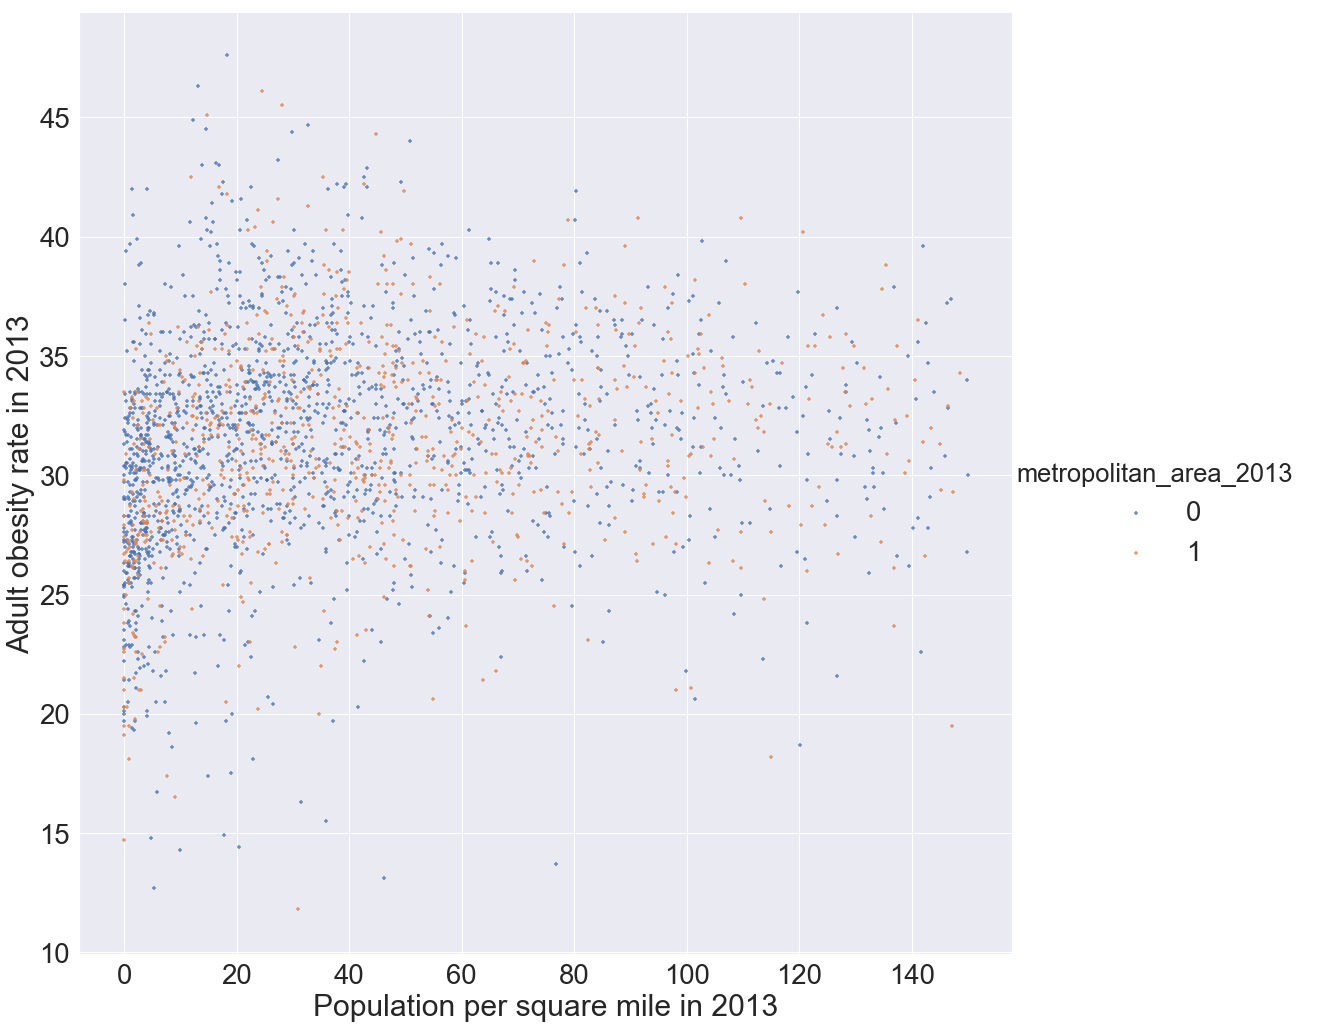

In [17]:
df_obesity = pd.read_csv(path_obesity)
df_metro = pd.read_csv(path_metropolitan)
df_metro.rename(columns={'fips':'county_fips', 'metropolitain_area_2013': 'metropolitan_area_2013'}, inplace=True)
df_obese_metro = df_obesity[['county_fips','PCT_obese_adults_2013']]
df_obese_metro = df_metro.merge(df_obesity[['county_fips',
                                                         'PCT_obese_adults_2013']], 
                                            how='inner', on='county_fips')
sns.set(font_scale=2.5)
scatter_graph = sns.lmplot(x='PSM_population_density_2013', y='PCT_obese_adults_2013', hue="metropolitan_area_2013" \
                           ,data=df_obese_metro.drop(df_obese_metro[df_obese_metro.PSM_population_density_2013 > 150].index), \
           height=15, markers='+', scatter_kws={"s": 20}, fit_reg=False)
scatter_graph.set_axis_labels('Population per square mile in 2013','Adult obesity rate in 2013')

In [18]:
df_metro.head()
df_metro_describe = df_obese_metro.drop(df_obese_metro[df_obese_metro.metropolitan_area_2013 < 1]
                                        .index)
df_non_metro_describe = df_obese_metro.drop(df_obese_metro[df_obese_metro.metropolitan_area_2013 > 0]
                                            .index)

In [19]:
df_non_metro_describe['PCT_obese_adults_2013'].describe()

count    1973.000000
mean       31.144450
std         4.529695
min        12.700000
25%        28.400000
50%        31.300000
75%        33.900000
max        47.600000
Name: PCT_obese_adults_2013, dtype: float64

In [20]:
df_metro_describe['PCT_obese_adults_2013'].describe()

count    1167.000000
mean       30.790231
std         4.495602
min        11.800000
25%        28.100000
50%        31.000000
75%        33.700000
max        46.100000
Name: PCT_obese_adults_2013, dtype: float64

The graph shows obesity rates from 2013 against population per square mile in 2013. Metropolitan areas are shown as orange dots whereas non-metropolitan ones are shown as blue dots. There is not any noticeable difference in obesity rates between metropolitan and non-metropolitan areas. At the same time, population per sqaure mile has no effect on obesity rate whatsoever. However based on the descriptive values above, there is a difference albeit a small one. The are almost twice as many non-metropolitan counties compared to metropolitan ones. Additionally the average obesity rate of metropolitan areas is 0.35 percent lower than the non-metropolitan one. The lowest metropolitan obesity rate is also 0.9 percent lower, the first quartile 0.3 lower, the median 0.3 lower and third quartile 0.2 lower and highest metropolitan obesity rate is 1.5 percent lower compared to the non-metropolitan ones. The differences are only slight, which is mainly why they did not show on the graph.

Further analysis of obesity rates was carried out in isolation. Since obesity is the main subject of the paper,  its data from different years was looked into.

# Obesity 
**Definition:** Estimate of age-adjusted percentage of persons age 20 and older who are obese, where obesity is Body Mass Index (BMI) greater than or equal to 30 kilograms per meters squared.   
**Source:** Estimates are from Centers for Disease Control and Prevention (CDC). CDC used data from the Behavioral Risk Factor Surveillance System (BRFSS) for 2008, 2009, and 2010 and from the U.S. Census Bureau. 

The puprose of this analysis is to explore the differences in Obesity rates from different years and how strong these differences are. For clarity purposes the counties are being categorised into buckets. An accuracy of 0.5 percent was chosen as the most adequate one.

**Distribution Plots**

In [21]:
def plot_distribution(title, series, lower_limit, upper_limit, bin_precision, y_limit, color):
    bins = np.linspace(lower_limit, upper_limit, ((upper_limit - lower_limit) / bin_precision) + 1)
    sns.set_color_codes()
    sns.set(font_scale=2)
    plt.subplots(figsize=(20,8))
    plt.title(title) 
    plt.xlim(lower_limit, upper_limit)
    plt.ylim(0, y_limit)
    plt.ylabel("Number of counties")
    sns.distplot(series.dropna(), bins=bins, color=color, kde=False, axlabel='Adult obesity rate ')  

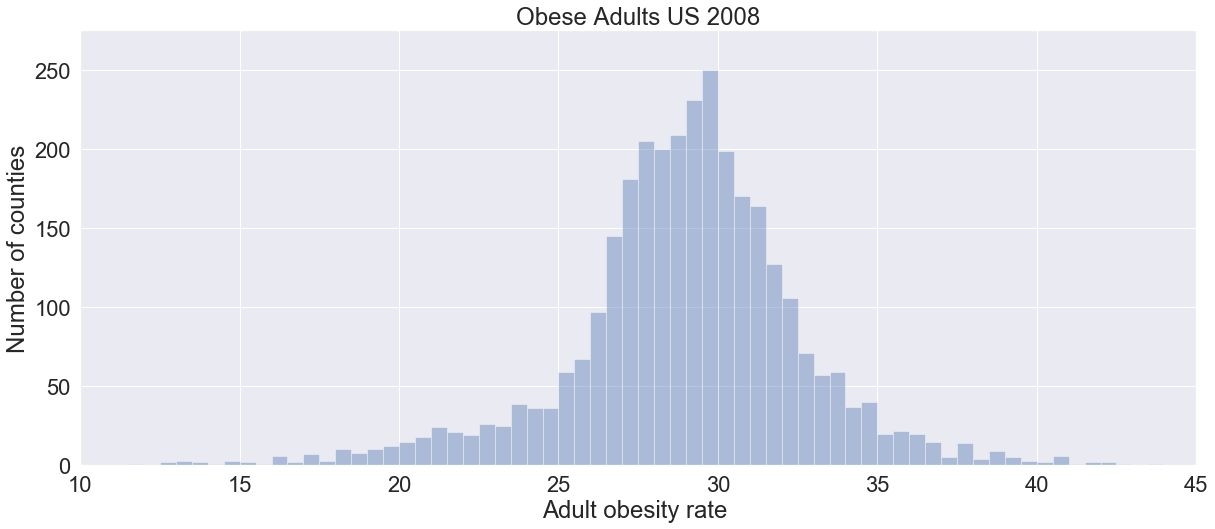

In [22]:
df_obesity = pd.read_csv(path_obesity)
plot_distribution('Obese Adults US 2008', df_obesity['PCT_obese_adults_2008'], 10, 45, 0.5, 275,  'b')

The histogram shows the different obesity rates and the number of counties which fall into these obesity buckets. These data are from 2008 and they show a typical gaussian(normal) distribution, where the bucket with most counties, 250 to be exact, has an obesity rate of 30 percent.


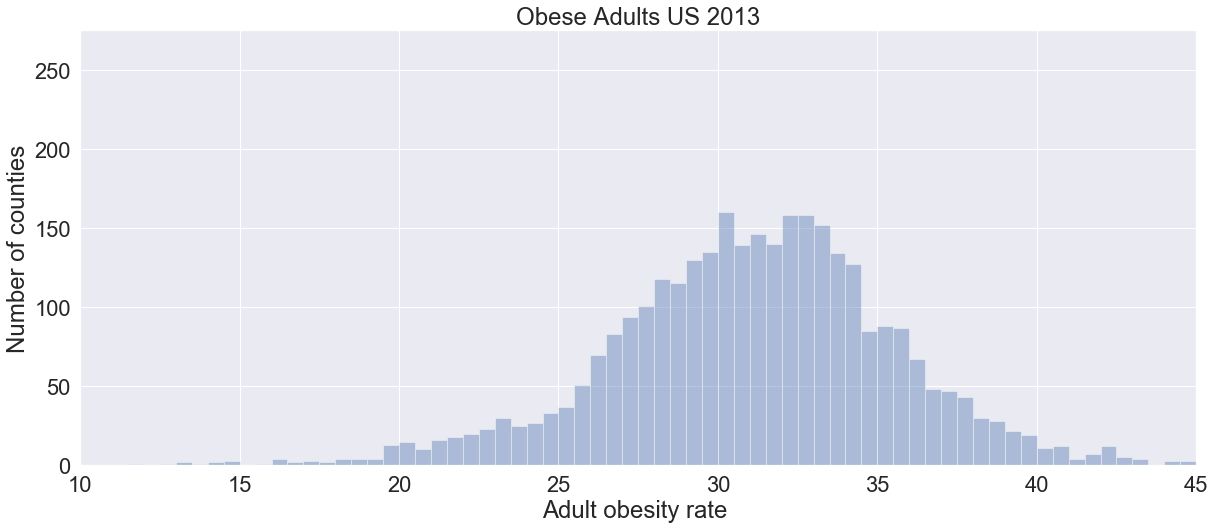

In [23]:
plot_distribution('Obese Adults US 2013', df_obesity['PCT_obese_adults_2013'], 10, 45, 0.5, 275, 'b')

Data recorded in 2013 on the other hand, show that the distribution is more widely spread, in other words, the standard deviation is bigger; 3.711 in 2008 and 4.523 in 2013, to be more precise.  The biggest bucket here is about 160 counties with an obesity rate of 30.5 percent.

For more accurate information, descriptive statistics were also generated including averages of obesity rates from 2008 and 2013 and percentage change from 2008 to 2013:

In [24]:
ob_columns = ['PCT_obese_adults_2008','PCT_obese_adults_2013','PCT_obese_adults_average','PCT_obese_adults_change']
df_obesity_description = round(df_obesity[ob_columns].describe(), 3).transpose()
df_obesity_description.rename(index={df_obesity_description.index[0]:'Adult obesity rate 2008',
                                      df_obesity_description.index[1]:'Adult obesity rate 2013',
                                      df_obesity_description.index[2]:'Average of adult obesity rate from 2008 & 2013',
                                      df_obesity_description.index[-1]:'Percentage change of adult obesity rate \
                                      from 2008 to 2013'})

,count,mean,std,min,25%,50%,75%,max
Adult obesity rate 2008,3138.0,28.931,3.711,11.70,27.20,29.10,31.00,43.7
Adult obesity rate 2013,3142.0,31.017,4.523,11.80,28.30,31.20,33.80,47.6
Average of adult obesity rate from 2008 & 2013,3137.0,29.974,3.935,12.35,27.85,30.25,32.35,45.0
Percentage change of adult obesity rate from 2008 to 2013,3137.0,2.086,2.566,-6.90,0.40,2.00,3.70,13.0


The most noteworthy value here is the low standard deviation value of the percentage change of diabetes (last row). To better understand what this value is saying a histogram of the percentage change of obesity from 2008 to 2013 was plotted.

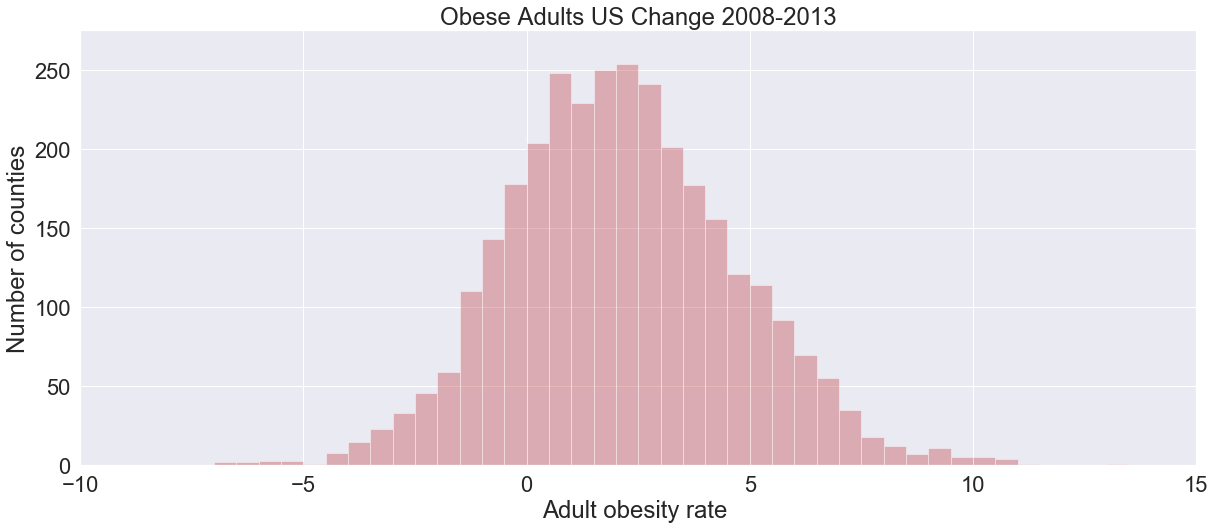

In [25]:
plot_distribution('Obese Adults US Change 2008-2013', df_obesity['PCT_obese_adults_change'], -10, 15, 0.5, 275, 'r')

The findings of this histogram are to be noticed. The first observation is that, obesity rates throughout these years have slightly increased for the most part. The second observation is that, the percentage increase between counties is similar, with the majority of these ranging between 0% and 4%, which is what the low standard deviation value showed previously. This means the data have stability, which would justify a linear interpolation as a means of higher accuracy, in case one is required at a later stage.

For further data exploration, the variable list spreadsheet was thoroughly examined for possible factors that might corelate with obesity.

# Diabetes
**Definition:** Estimates of age-adjusted percentage of persons age 20 and older with diabetes (gestational diabetes excluded).   
**Source:** Estimates are from Centers for Disease Control and Prevention (CDC). CDC used data from the Behavioral Risk Factor Surveillance System (BRFSS) for 2008, 2009, and 2010 and from the U.S. Census Bureau. The methodology is described on the CDC's County Estimates page. 

As a baseline obesity rate was put up against diabetes rate, which is more of a ramification/result rather than a cause for obesity. The aim was to examine the correlations between variables that are directly related to each other and how strong these correlations are, and the aim is purely observational not analytical.

In [26]:
df_obesity = pd.read_csv(path_obesity)
df_diabetes = pd.read_csv(path_diabetes)
df_obese_diabetes = df_obesity[['county_fips','PCT_obese_adults_2013']]
df_obese_diabetes = df_obese_diabetes.merge(df_diabetes[['county_fips',
                                                         'PCT_diabetes_adults_2013']], 
                                            how='inner', on='county_fips')

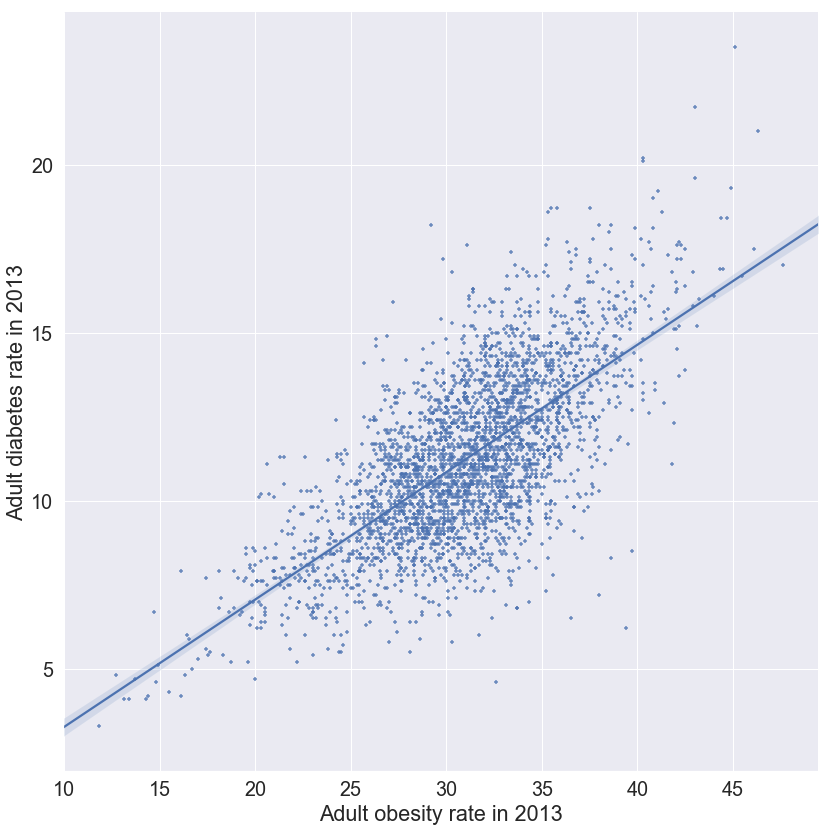

In [27]:
sns.set(font_scale=1.8)
scatter_graph = sns.lmplot(x='PCT_obese_adults_2013', y='PCT_diabetes_adults_2013', data=df_obese_diabetes, \
           height=12, markers='+', scatter_kws={"s": 10})
scatter_graph.set_axis_labels('Adult obesity rate in 2013','Adult diabetes rate in 2013')

The scatter graph shows a positive relationship between obesity and diabetes, but the graph is not very clear due to the fact that too many points overlap with each other. To solve this, a hex graph better shows where the points lie, by using darker colouring on the graph, when points are densely packed together.

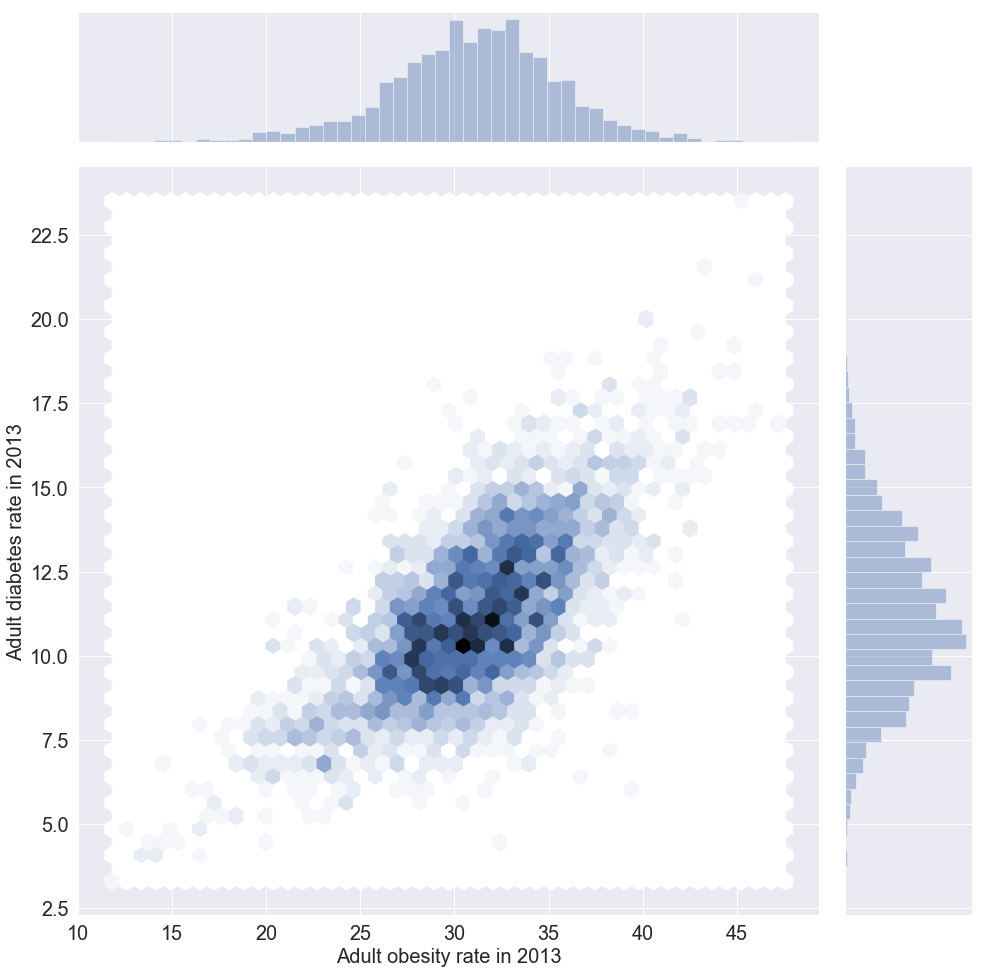

In [28]:
hex_graph = sns.jointplot(x='PCT_obese_adults_2013', y='PCT_diabetes_adults_2013', data=df_obese_diabetes,
              kind='hex', height=14)
hex_graph.set_axis_labels('Adult obesity rate in 2013','Adult diabetes rate in 2013', size = 20)

The hex graph reveals that the relationship is not as strong as one would have expected. There are multiple reasons as to why this is. Firstly, obesity is known as a main cause of type II diabetes, but not type I! Secondly there are obese people, who do not suffer from diabetes and vice versa, there are diabetics who are not obese. Addidionally, there is the fact that the data are county based and not on an individual level, which means that the linkage between obesity and diabetes between individuals gets lost.

# Fast Food Restaurants

**Definition:** The number of limited-service restaurants in the county. Limited-service restaurants (defined by North American Industry Classification System (NAICS) code 722211) include establishments primarily engaged in providing food services (except snack and nonalcoholic beverage bars) where patrons generally order or select items and pay before eating. Food and drink may be consumed on premises, taken out, or delivered to the customer's location. Some establishments in this industry may provide these food services in combination with alcoholic beverage sales.   
**Source:** Restaurant data are from the U.S. Census Bureau, County Business Patterns.
 

Studies have shown that rises in obesity rates among the world population could be attributed to an increase in calorie intake coupled with lack of adequate physical activity. Fast food is regarded as a low quality, calorically dense food. For this reason, the number of fast food restaurants, and its effect on obesity was assessed. As a first step the number of empty values, in other words the number of counties with no record of the number of fast food restaurants, was calculated. The desired data, which are the records from 2014 have no empty entries.

Relevant data from the atlas were recorded in 2009 and in 2014. This gives rise to the problem that obesity and fast food data are recorded in different years. However, due to the low standard deviation value of the percentage change of obesity, as well as the assumption that realistically the number of people who are cured from obesity within one year’s time, is extremely low, the two can still be plotted against each other with relatively high accuracy.

As a first step the data is being checked for nan values 

In [29]:
df_restaurants = pd.read_excel(path_atlas, sheet_name='RESTAURANTS')
df_fast_food = df_restaurants[['State', 'PC_FFRSALES07', 'PC_FFRSALES12' ]].copy()
print('{:<25} {:d}'.format('Number of entries including nan values:', len(df_fast_food.index)))
#Number of Entries excluding null values
df_fast_food_without_nan = df_fast_food.dropna()
print('{:<25} {:d}'.format('Number of entries excluding nan values:', len(df_fast_food_without_nan.index)))

Number of entries including nan values: 3143
Number of entries excluding nan values: 3143


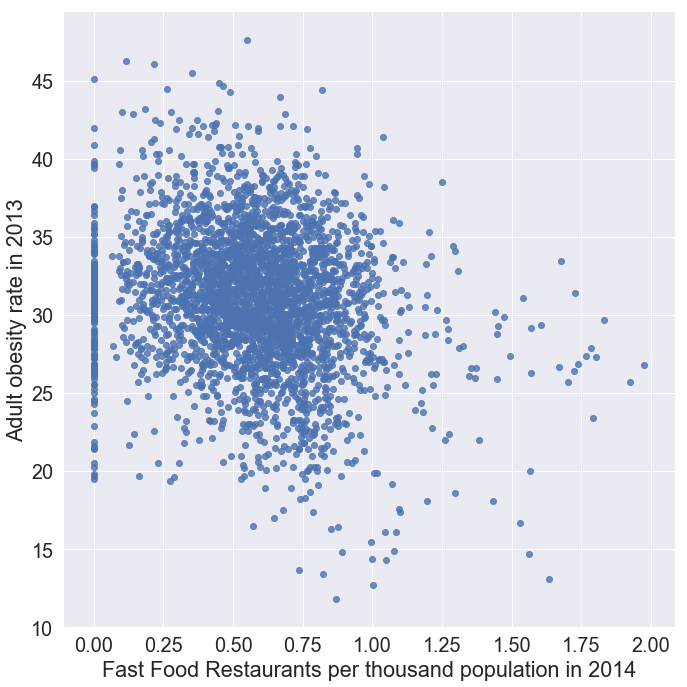

In [30]:
df_obesity = pd.read_csv(path_obesity)
df_fast_food = pd.read_csv(path_fast_food)
df_obese_fast_food = df_obesity[['county_fips','PCT_obese_adults_2013']]
df_obese_fast_food = df_obese_fast_food.merge(df_fast_food[['county_fips','CPT_fast_food_2014']], how='inner', on='county_fips')
sns.set(font_scale=1.8)
scatter_graph_fast_food = sns.lmplot(x='CPT_fast_food_2014', y='PCT_obese_adults_2013',
                                     data=df_obese_fast_food.drop(df_obese_fast_food
                                                                  [df_obese_fast_food.CPT_fast_food_2014 > 2].index), 
                                     height=10, fit_reg=False)
scatter_graph_fast_food.set_axis_labels('Fast Food Restaurants per thousand population in 2014','Adult obesity rate in 2013')

Despite too much overlapping between the points, the graph gives the following clear message, which is, that there is no correlation between obesity and the number of fast food restaurants. That is to be half expected, since the number of restaurants says basically nothing about the costumers who go there, for instance how often they dine at such places or how much food they eat when they go there. This means that the expenditure at fast food restaurants would make a better canditate to evaluate whether obesity and fast food consumption have a relationship. But before this test was run, fast food expenditure and fast food restaurant count were plotted against each other. It is to be expected, that the two are related since from a rational perspective, more money is spent somewhere, where there are a lot of fast food restaurants as oppose to a place where there are only a few. The purpose of this comparison is once again experimental, where the goal is to examine the relationship between two variables that are tightly connected.

# Fast Food Expenditure
**Definitions:** Average expenditures (in current dollars) on food purchased at limited-service restaurants (defined by North American Industry Classification System (NAICS) code 7222) by county residents. Limited-service restaurants include establishments primarily engaged in providing food services (except snack and nonalcoholic beverage bars) where patrons generally order or select items and pay before eating. Food and drink may be consumed on premises, taken out, or delivered to the customer's location. Some establishments in this industry may provide these food services in combination with selling alcoholic beverages.    
 **Source:** Economic Census, Accommodation and Food Services: Geographic Area Series, accessed at U.S. Census Bureau, American Factfinder. Population data are from the U.S. Census Bureau, Population Estimates. 

Plotting Fast food expenditure per capita against fast food restaurants per 1000 population gave rise to two challenges. One was the fact that Expenditure was recorded on a state level as oppose to fast food restaurant count which was on a county level. To bring the scope of the two variables on the same level, the sum of fast food restaurants of all counties in a given state was calculated. Secondly, the expenditure was recorded in 2007 and 2012 but restaurant numbers were recorded in 2009 and 2014. To rectify this problem, the number of fast food restaurants was linearly interpolated to 2012.

In [31]:
df_fastfood_expenditure = pd.read_csv(path_fast_food_expenditure)
df_fastfood_count = pd.read_csv(path_fast_food_restaurant_count)
df_ff_merged = df_fastfood_count[['State','CPT_fast_food_2009']]
df_ff_merged['CPT_fast_food_2012'] = df_fastfood_count['CPT_fast_food_2012']
df_ff_merged['CPT_fast_food_2014'] = df_fastfood_count['CPT_fast_food_2014']
df_ff_merged['EXP_per_cap_2012'] = df_fastfood_expenditure['EXP_per_cap_in_$_2012']

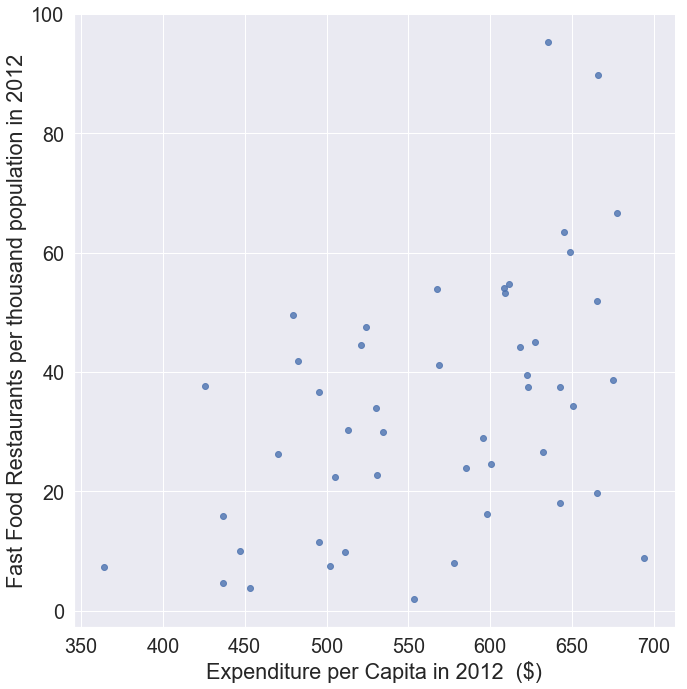

In [32]:
scatter_graph_fast_food_expenditure = sns.lmplot(x='EXP_per_cap_2012', y='CPT_fast_food_2012', 
                                                 data=df_ff_merged.drop(df_ff_merged[df_ff_merged.EXP_per_cap_2012 
                                                                                     >700].index), fit_reg=False, height=10)
scatter_graph_fast_food_expenditure.set_axis_labels('Expenditure per Capita in 2012  ($)',
                                                    'Fast Food Restaurants per thousand population in 2012')

Unexpectedly, there is no correlation to be seen from the graph. One of the main reasons, why this happened, is due to the scope of the data. This is seen again, when we calculate obesity on a state level, in this case, the median value of all counties that belong to a given state.

In [33]:
df_obesity_grouped = df_obesity.groupby('state', as_index=False).median()
df_ff_merged['PCT_obese_adults_2013'] = df_obesity_grouped['PCT_obese_adults_2013']
df_ff_merged['PCT_obese_adults_2013'].describe().transpose()

count    51.000000
mean     29.762745
std       3.949479
min      20.500000
25%      27.550000
50%      30.000000
75%      32.350000
max      36.850000
Name: PCT_obese_adults_2013, dtype: float64

When we combine the obesity data of counties in their states, we get values which are very close to the average. This is verified by the small standard deviation value in the description frame. This means working with data on a state level does not make much sense and this is because we lose too much information resolution along the way.

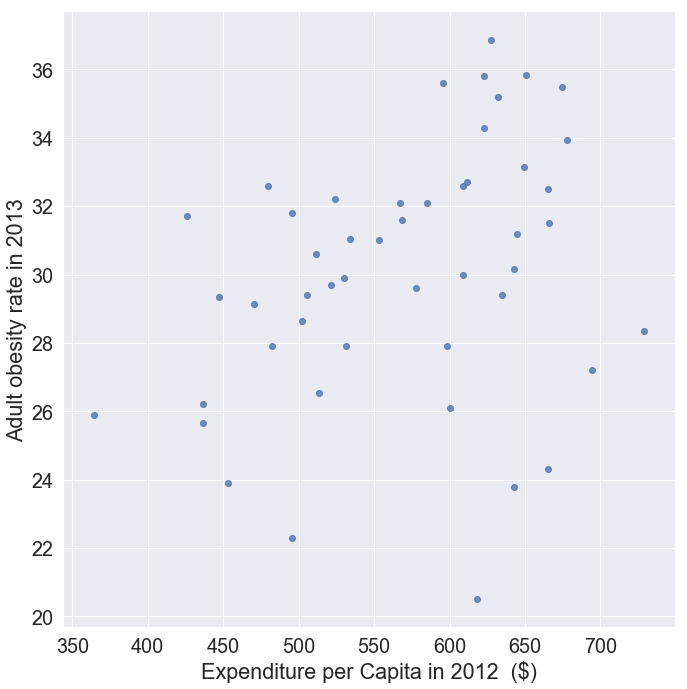

In [34]:
scatter_graph_fast_food_expenditure_against_obese = sns.lmplot(x='EXP_per_cap_2012', y='PCT_obese_adults_2013',
                                                                data=df_ff_merged.drop(
                                                                    df_ff_merged[df_ff_merged.EXP_per_cap_2012 >800]
                                                                    .index), fit_reg=False, height=10)
scatter_graph_fast_food_expenditure_against_obese.set_axis_labels('Expenditure per Capita in 2012  ($)',
                                                    'Adult obesity rate in 2013')

For demonstration purposes, obesity against expenditure is graphed, to highlight the points, which were previously mentioned. The fact that obesity was recorded in 2013 and expenditure in 2012 has no significant impact on the accuracy of the graph since realistically, it is highly unlike that obesity rates will change a lot in a year's time. This was also statistically verified above. The next variable, which was examined was Households without a car and low access to stores.

# Households without a car and low access to stores 
**Definitions:** Percentage of housing units in a county without a car and more than 1 mile from a supermarket, supercenter or large grocery store.    
 **Source:** Data are from the 2012 report,  Access to Affordable and Nutritious Food: Updated  Estimates of Distances to Supermarkets Using 2015 Data. In this report, a directory of supermarkets, supercenters and large grocery stores within the United States, including Alaska and Hawaii, was derived from merging the 2015 STARS directory of stores authorized to accept SNAP benefits and the 2015 Trade Dimensions TDLinx directory of stores. Stores met the definition of a supermarket, supercenter, or large grocery store if they reported at least $2 million in annual sales and contained all the major food departments found in a traditional supermarket, including fresh meat and poultry, dairy, dry and packaged foods, and frozen foods. The combined list of supermarkets and large grocery stores was converted into a GIS-usable format by geocoding the street address into store-point locations. Population data are reported at the block level from the 2015 Census of Population and Housing. These population data were aerially allocated down to ½-kilometer-square grids across the United States. For each ½-kilometer-square grid cell, the distance was calculated from its geographic center to the center of the grid cell with the nearest supermarket. Rural or urban status is designated by the Census Bureau’s Urban Area definition. 

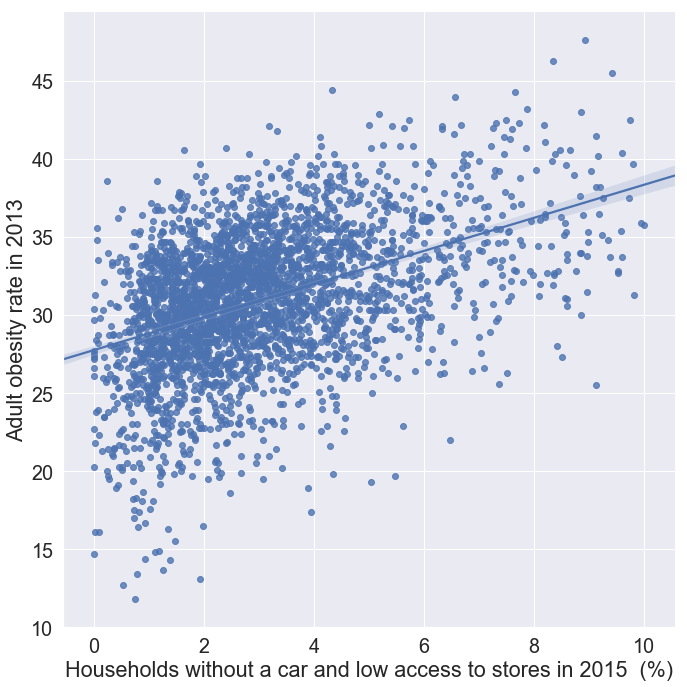

In [37]:
df_access = pd.read_excel(path_atlas, sheet_name='ACCESS')
df_low_access = df_access[['FIPS','PCT_LACCESS_HHNV15']].copy()
df_low_access.rename(columns={'FIPS':'county_fips','PCT_LACCESS_HHNV15':'PCT_no_car_low_access_hs_2015'}, inplace=True)
df_obese_low_access = df_obesity[['county_fips','PCT_obese_adults_2013']]
df_obese_low_access = df_obese_low_access.merge(df_low_access[['county_fips','PCT_no_car_low_access_hs_2015']], 
                                                how='inner', on='county_fips')
scatter_graph_low_access = sns.lmplot(x='PCT_no_car_low_access_hs_2015', y='PCT_obese_adults_2013', 
           data=df_obese_low_access.drop(df_obese_low_access[df_obese_low_access.PCT_no_car_low_access_hs_2015 > 10].index),
           height=10)
scatter_graph_low_access.set_axis_labels('Households without a car and low access to stores in 2015  (%)', 
                                         'Adult obesity rate in 2013')

In [36]:
df_low_access_description = df_low_access.drop(['county_fips'], axis=1).describe().transpose().round(3)
df_low_access_description.rename(index={df_low_access_description.index[0]:
                                 'Percentage of households without car and low access to stores in 2015'})

,count,mean,std,min,25%,50%,75%,max
Percentage of households without car and low access to stores in 2015,3140.0,3.289,3.213,0.0,1.683,2.673,4.036,60.602


This time the graph shows a very weak connection between the two variables, but a connection nevertheless . The variables might be two years apart from each other but obesity has already been tested for data stability. It would have been interesting to see whether spending in fast food restaurants has a connection to low access in stores, in other words, whether people with low access to stores eat at fast food restaurants more frequently, but due to the fact that expenditure is on a state level, and we already know data on a state level are too generalised, this would unfortunately give no relevant information.

# Conclusion
The state level geo data show a definite distinction between states. Those with the lowest income are also those who suffer from the highest obesity rates. Oklahoma, Louisiana, Arkansas, Mississippi, Alabama, South Carolina and West Virginia are the states with the highest obesity rates.
The county level geo data show that metropolitan areas have lower obesity rates than non-metropolitan ones. The population density graph on the other hand shows that there are no differences between metropolitan and non-metropolitan areas. But cities like San franscisco and New York City have significantly lower rates. This suggests that megacities like the ones just mentioned are in a category of their own.
Obesity rates have seen a slight increase through the years 2008 and 2013.
Observational results from graphs with diabetes, which is a result of obesity, and obesity, are not as strong as expected.
Plotting single possible factors against obesity never yields the desired or expected results. This is probably due to the fact that obesity is a chronic disease and hence is influenced by many factors.